# Algorithmic Trading Model for Trend-Following with Holding Period Strategy Using Python Take 1
### David Lowe
### January 27, 2021

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: This project aims to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This algorithmic trading model examines a simple trend-following strategy for a stock. The model buys a stock when the price reaches the highest price for the last X number of days. The model will exit the position when the stock price crosses below the mean of the same window size.

In addition to the stock price, the models will also use the trading volume indicator to confirm the buy/sell signal further. Finally, the strategy will also incorporate a fixed holding window. The system will exit the position when the holding window reaches the maximum window size.

In this Take1 iteration, we will set up the models using a trend window size for long trades only. The window size varied from 10 to 50 trading days at a 5-day increment. The models will also consider a volume indicator with a varying window size between 10 and 15 days to further confirm the buy/sell signal. We will not limit the holding period by setting the maximum holding period to 99 days for this iteration.

ANALYSIS: In this Take1 iteration, we analyzed the stock prices for Apple Inc. (AAPL) between January 1, 2018, and December 31, 2020. The trading model produced a profit of 95.90 dollars per share. The buy-and-hold approach yielded a gain of 91.54 dollars per share.

CONCLUSION: For the stock of AAPL during the modeling time frame, the trading strategy produced a slightly better return than the buy-and-hold approach. We should consider modeling this stock further by experimenting with more variations of the strategy.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Quandl

An algorithmic trading modeling project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Acquire and Pre-Process Data
3. Implement and Train Models
4. Back-test Models
5. Evaluate Strategy Performance

## Task 1 - Prepare Environment

In [1]:
# # Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# # Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# # Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
#
# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# # Retrieve the CPU information
# ncpu = !nproc
# print("The number of available CPUs is:", ncpu[0])

### 1.a) Load libraries and modules

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from datetime import date, datetime, timedelta
import requests
import json
from dotenv import load_dotenv
# import pandas_datareader.data as pdr

# Begin the timer for the script processing
startTimeScript = datetime.now()

### 1.b) Set up the controlling parameters and functions¶

In [6]:
# Specify the key modeling parameters below
STOCK_SYMBOL = 'AAPL'
INITIAL_CAPITAL = 0

# Specify the moving average parameters for the trading strategy
WINDOW_MIN = 10
WINDOW_MAX = 50
WINDOW_INCREMENT = 5
VOL_MA_MIN = 10
VOL_MA_MAX = 15
VOL_MA_INCREMENT = 5
HOLDING_MAX = 99
HOLDING_MIN = 99
HOLDING_INCREMENT = 5

# The number of extra days of data we need for calculating moving averages (usually equals to the largest value of slow MA)
EXTRA_DAYS = WINDOW_MAX

MODEL_START_DATE = date(2018, 1, 1)
print("Starting date for the model:", MODEL_START_DATE)

# MODEL_END_DATE = datetime.now().date()
MODEL_END_DATE = date(2020, 12, 31)
print("Ending date for the model:", MODEL_END_DATE)

# data_start_date = MODEL_START_DATE
data_start_date = MODEL_START_DATE - timedelta(days=int(EXTRA_DAYS * 1.5)) # Need more pricing data to calculate moving averages
print("First date of data we need for modeling:", data_start_date)

data_end_date = MODEL_END_DATE
print("Last date of data we need for modeling:", data_end_date)

Starting date for the model: 2018-01-01
Ending date for the model: 2020-12-31
First date of data we need for modeling: 2017-10-18
Last date of data we need for modeling: 2020-12-31


In [7]:
# Specify the script running parameters below

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)

# Configure the plotting style
plt.style.use('seaborn')

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose_signals = False
verbose_models = True
verbose_graphs = True
verbose_portfolios = False
verbose_transactions = False
verbose_positions = True

In [8]:
# Set up the parent directory location for loading the dotenv files

# Mount Google Drive locally for storing files
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

# Set up access to the dotenv file on local PC
env_path = "/Users/david/PycharmProjects/"
dotenv_path = env_path + "python_script.env"
load_dotenv(dotenv_path=dotenv_path)

True

## Task 2 - Acquire and Pre-Process Data

In [9]:
# Set up the data service provider and data acquisition parameters
data_service = 'Quandl'

# Check and see whether the API key is available
api_key = os.environ.get('QUANDL_API')
if api_key is None: sys.exit("API key for Quandl not available. Script Processing Aborted!!!")

start_date_string = data_start_date.strftime('%Y-%m-%d')
end_date_string = data_end_date.strftime('%Y-%m-%d')
api_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s" % (start_date_string, end_date_string, STOCK_SYMBOL, api_key)
response = requests.get(api_url)
resp_dict = json.loads(response.text)
stock_rawdata = pd.DataFrame(resp_dict['datatable']['data'])
print(len(stock_rawdata), 'data points retrieved from the API call.')

807 data points retrieved from the API call.


In [10]:
stock_rawdata.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividend', 'closeunadj', 'lastupdated']
# stock_rawdata.set_index('date', inplace=True)
stock_rawdata.index = pd.to_datetime(stock_rawdata.date)
stock_pricing = stock_rawdata.sort_index(ascending=True)
print(stock_pricing.head())
print()
print(stock_pricing.tail())

           ticker        date    open    high     low   close       volume  dividend  closeunadj lastupdated
date                                                                                                        
2017-10-18   AAPL  2017-10-18  40.105  40.178  39.900  39.940   65496656.0       0.0      159.76  2020-08-31
2017-10-19   AAPL  2017-10-19  39.188  39.270  38.755  38.995  170336664.0       0.0      155.98  2020-08-31
2017-10-20   AAPL  2017-10-20  39.153  39.438  38.990  39.063   95896584.0       0.0      156.25  2020-08-31
2017-10-23   AAPL  2017-10-23  39.222  39.422  38.875  39.042   87937308.0       0.0      156.17  2020-08-31
2017-10-24   AAPL  2017-10-24  39.072  39.355  39.050  39.275   71028920.0       0.0      157.10  2020-08-31

           ticker        date    open     high      low   close       volume  dividend  closeunadj lastupdated
date                                                                                                          
2020-12-24   A

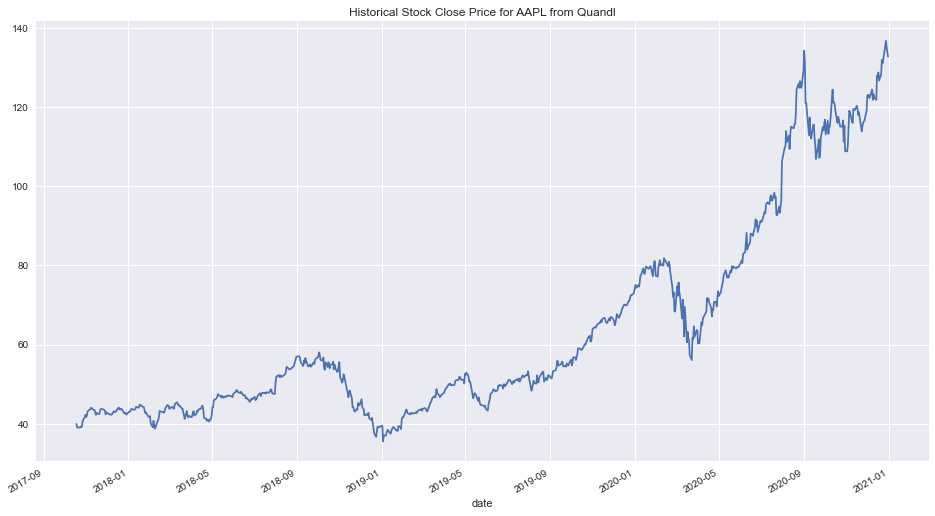

In [11]:
# Set up the standard column name for modeling
# Column names may be data-provider specific!
MODEL_TEMPLATE = stock_pricing.loc[:, ['open','close','volume']]
MODEL_TEMPLATE.rename(columns={'open': 'open_price', 'close': 'close_price', 'volume': 'trading_volume'}, inplace=True)
plot_title = 'Historical Stock Close Price for ' + STOCK_SYMBOL + ' from ' + data_service
MODEL_TEMPLATE['close_price'].plot(figsize=(16,9), title=plot_title)
plt.show()

## Task 3 - Implement and Train Models

In [12]:
# Define the function that will generate the indicators and trading signals
def populate_signals(window=WINDOW_MIN, vol_ma=VOL_MA_MIN, max_holding=HOLDING_MAX):

    trade_model = MODEL_TEMPLATE.copy()
    trade_model['window_high'] = trade_model['close_price'].shift(1).rolling(window=window).max()
    trade_model['window_low'] = trade_model['close_price'].shift(1).rolling(window=window).min()
    trade_model['window_avg'] = trade_model['close_price'].shift(1).rolling(window=window).mean()
    trade_model['volume_ma'] = trade_model['trading_volume'].rolling(vol_ma).mean()
    trade_model['holding_period'] = 0
    trade_model['trade_signal'] = 0
    trade_model['entry_exit'] = 0
    prior_signal = 0
    prior_ownership = False
    currently_own = False

    # Truncate the model to the required starting and ending dates
    trade_model = trade_model[MODEL_START_DATE:MODEL_END_DATE]

    for k in range(len(trade_model)):
        current_signal = 0
        breakout = trade_model.at[trade_model.index[k],'close_price'] - trade_model.at[trade_model.index[k],'window_high']
        crossover = trade_model.at[trade_model.index[k],'close_price'] - trade_model.at[trade_model.index[k],'window_avg']
        trade_volume = trade_model.at[trade_model.index[k],'trading_volume']
        average_volume = trade_model.at[trade_model.index[k],'volume_ma']
        trade_model.at[trade_model.index[k],'entry_exit'] = prior_signal
        if prior_signal == 1:
            currently_own = True
        elif  prior_signal == -1:
            currently_own = False
        else:
            currently_own = prior_ownership

        holding_period = trade_model.at[trade_model.index[k-1],'holding_period']
        if prior_ownership:
            holding_period = holding_period + 1
            trade_model.at[trade_model.index[k],'holding_period'] = holding_period

        if (breakout > 0) and (trade_volume > average_volume) and (not currently_own):
            current_signal = 1  # trade_signal = 1 means we should buy
            currently_own = True
        elif ((crossover < 0) and (trade_volume > average_volume) and currently_own) or ((holding_period == max_holding) and currently_own):
            current_signal = -1  # trade_signal = -1 means we should sell
            currently_own = False
        trade_model.at[trade_model.index[k],'trade_signal'] = current_signal
        prior_signal = current_signal
        prior_ownership = currently_own

    # Exiting the position on the last day of modeling period
    if currently_own:
        trade_model.at[trade_model.index[-1],'entry_exit'] = -1
    if verbose_signals: print(trade_model, '\n')
    return trade_model

In [13]:
# Build the collection of trading models by iterating through the parameters
trading_model_collection = {}
serial_no = 0
for window_size in range(WINDOW_MIN, WINDOW_MAX+1, WINDOW_INCREMENT):
    for vol_average in range(VOL_MA_MIN, VOL_MA_MAX+1, VOL_MA_INCREMENT):
        for hold_period in range(HOLDING_MIN, HOLDING_MAX+1, HOLDING_INCREMENT):
            serial_no += 1
            model_tag = 'Model_' + str(serial_no).zfill(3) + '_WINDOW_' + str(window_size).zfill(2) + '_VOLMA_' + str(vol_average).zfill(2) + '_HOLDING_' + str(hold_period).zfill(2)
            if verbose_signals: print('Processing model:', model_tag)
            trading_model = populate_signals(window_size, vol_average, hold_period)
            trading_model_collection[model_tag] = trading_model.copy()
print(len(trading_model_collection), 'trading models generated!')

18 trading models generated!


In [14]:
# List the entry/exit points for each model
def list_model_entry_exit(trade_model):
    print(trade_model[(trade_model['trade_signal'] != 0) | (trade_model['entry_exit'] != 0)])

In [15]:
if verbose_models:
    for model_name in trading_model_collection:
        print('List the signal changes and entry/exit points for model:', model_name)
        list_model_entry_exit(trading_model_collection[model_name])
        print()

List the signal changes and entry/exit points for model: Model_001_WINDOW_10_VOLMA_10_HOLDING_99
            open_price  close_price  trading_volume  window_high  window_low  window_avg    volume_ma  holding_period  trade_signal  entry_exit
date                                                                                                                                           
2018-01-12      44.045       44.273     101672320.0       43.820      42.307     43.2769   94946334.8               0             1           0
2018-01-16      44.475       44.047     118263788.0       44.273      42.307     43.4272   96372744.8               1             0           1
2018-01-24      44.313       43.555     204420360.0       44.815      43.572     44.2010  122607877.2               7            -1           0
2018-01-25      43.626       42.778     166116016.0       44.815      43.555     44.1982  129635520.8               0             0          -1
2018-05-04      44.563       45.958    

In [16]:
def draw_model_graph(trade_model, mdl_name=STOCK_SYMBOL):
    graph_data = trade_model.copy()
    title_string = 'Moving Average Crossover Momentum Trading Model for ' + mdl_name
    fig = plt.figure(figsize=(16,9))
    ylabel = STOCK_SYMBOL + ' price in $'
    ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
    graph_data['close_price'].plot(ax=ax1, color='g')
    ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
    ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
    plt.legend(loc='upper left')
    plt.show()

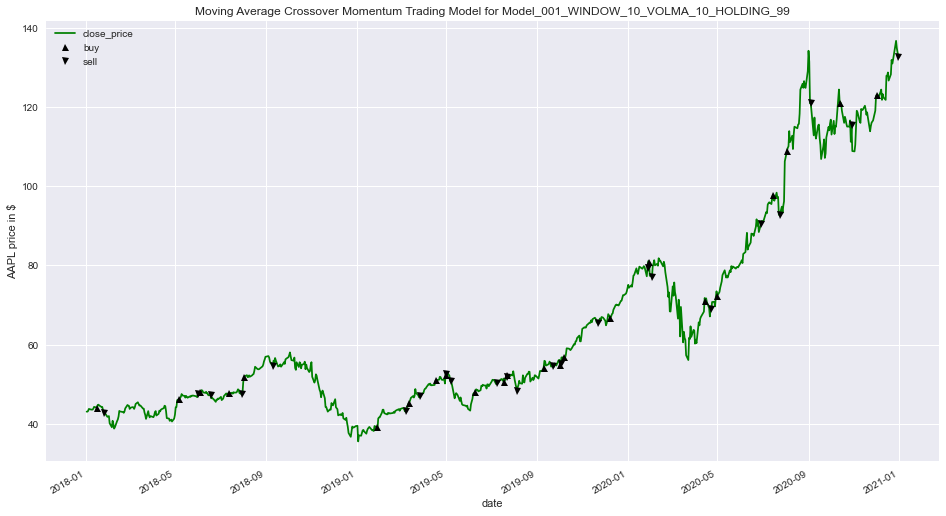

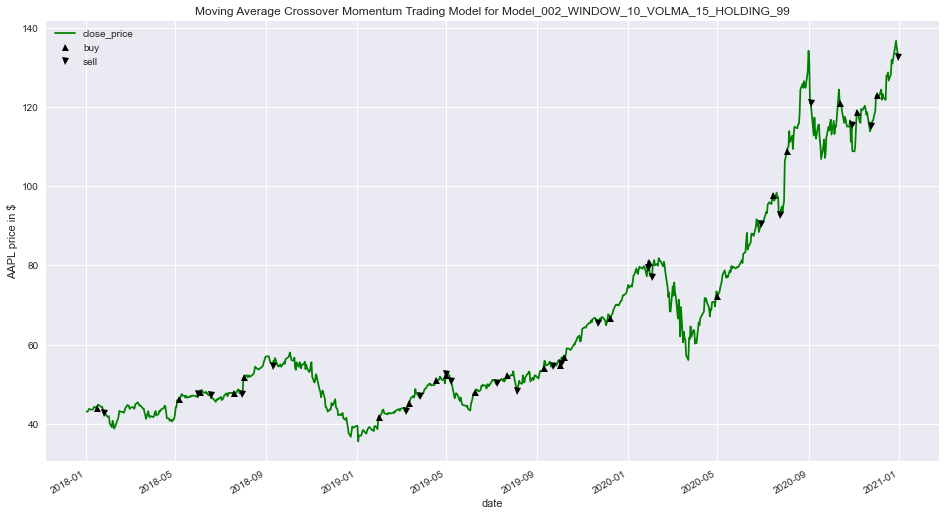

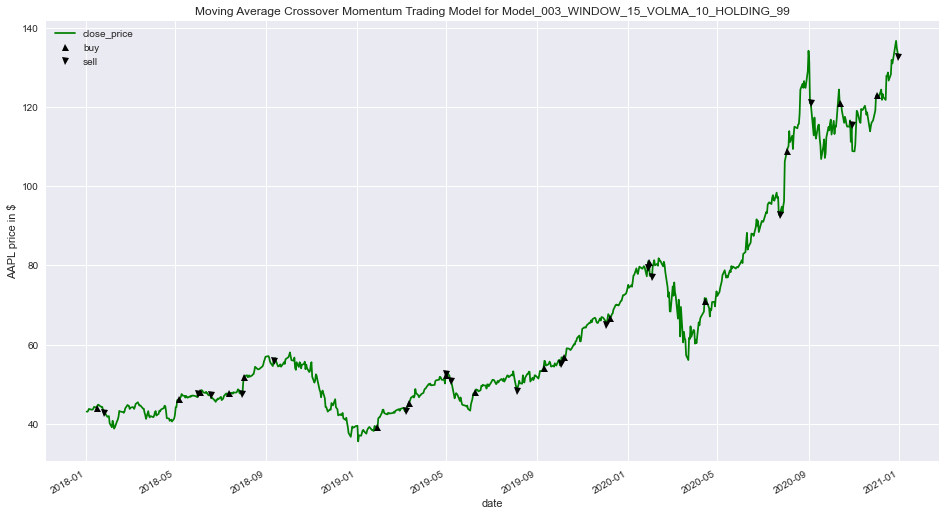

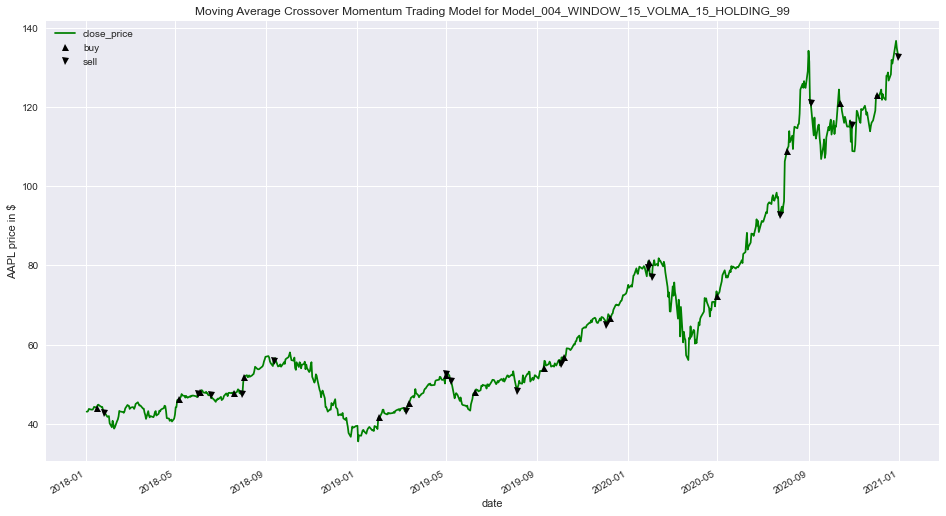

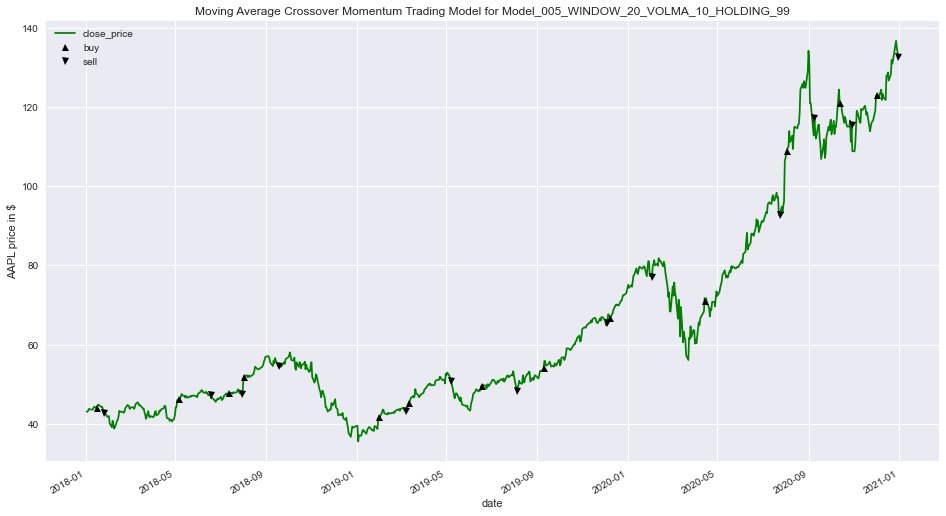

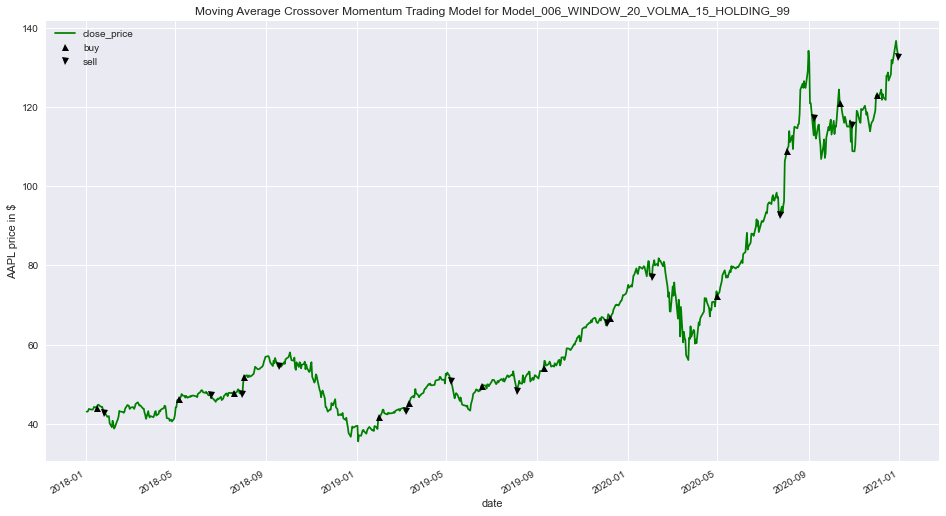

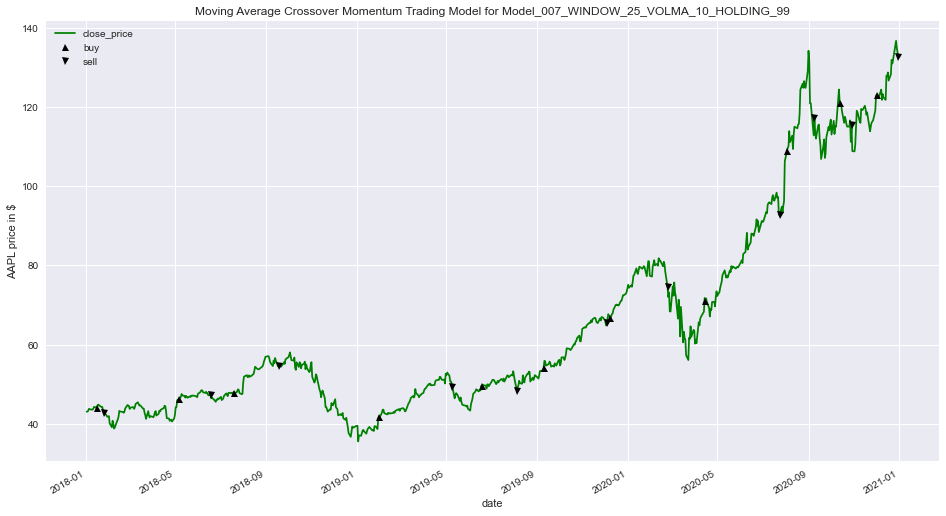

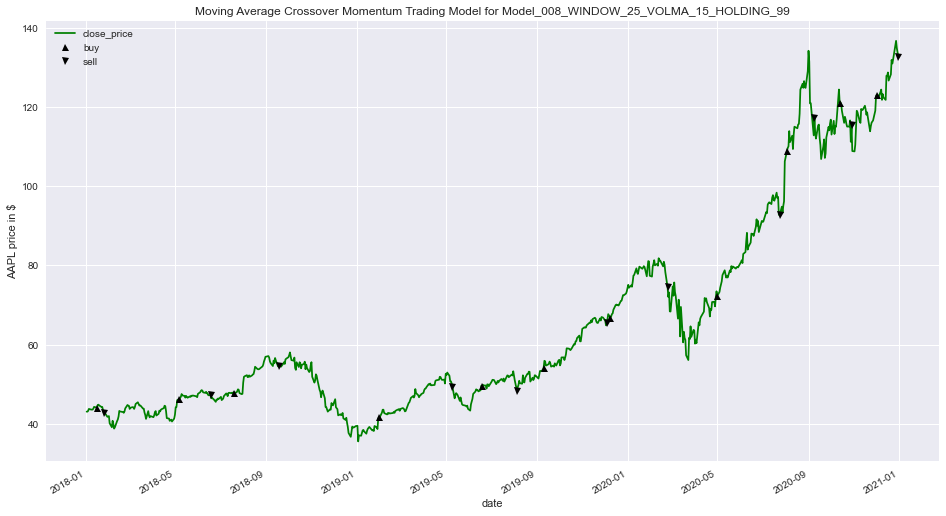

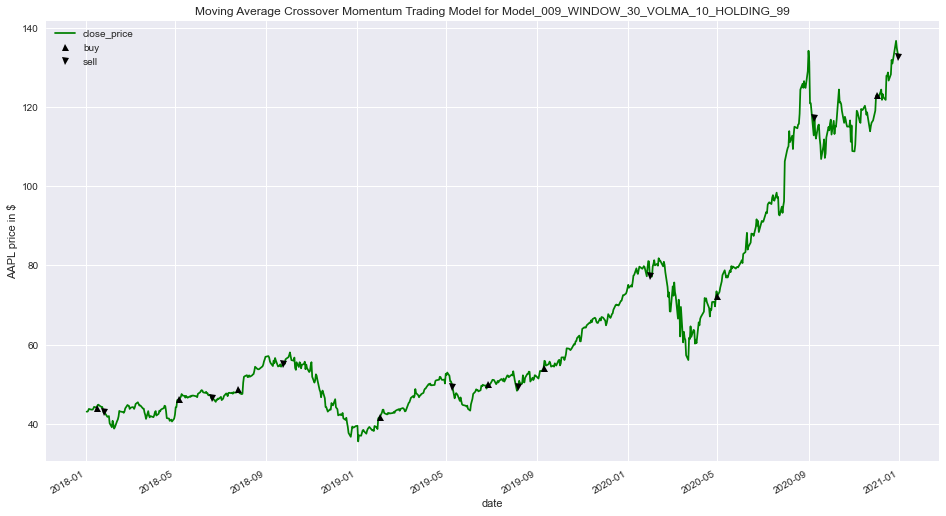

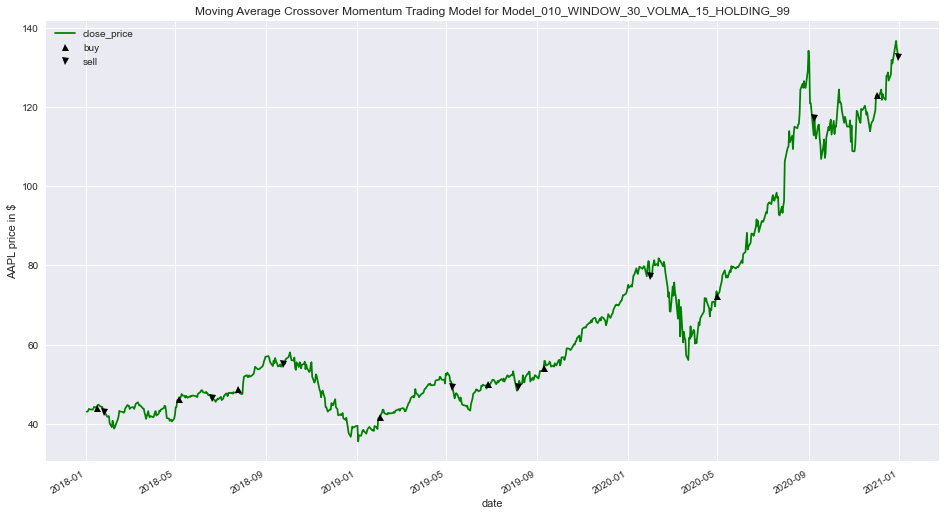

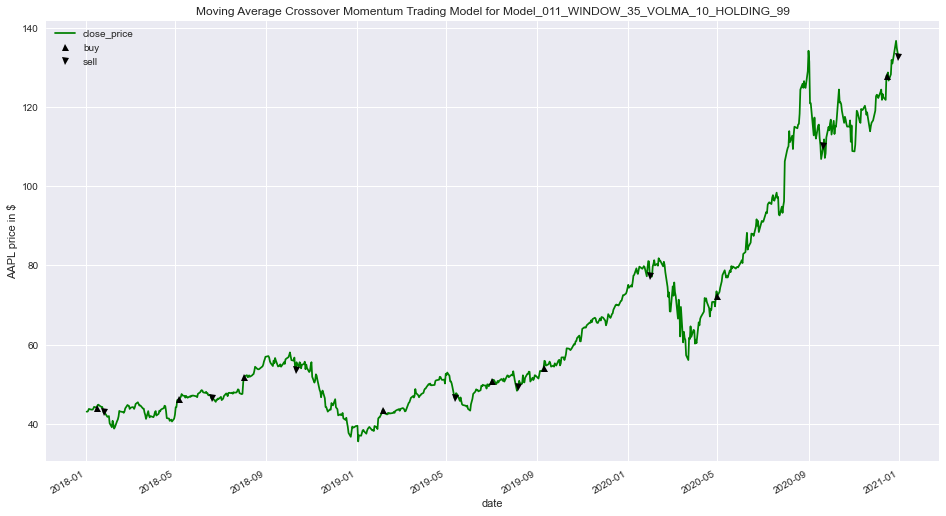

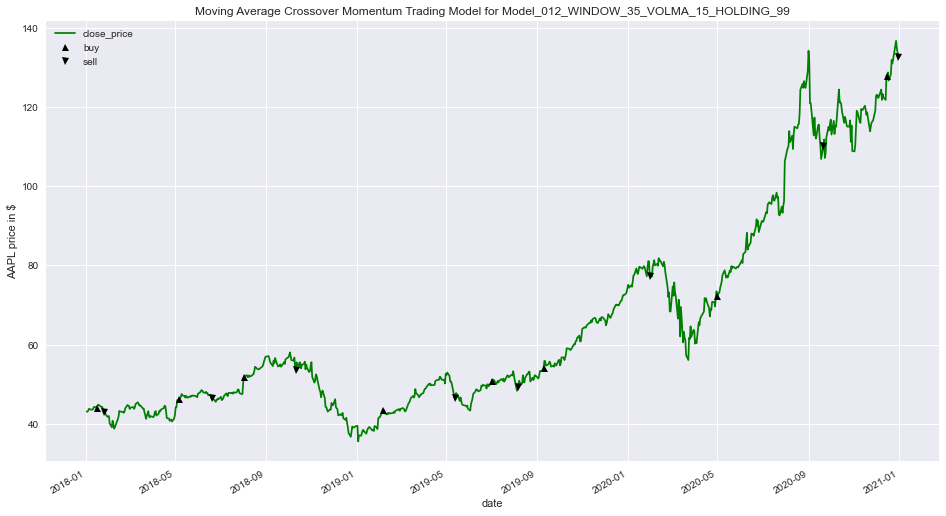

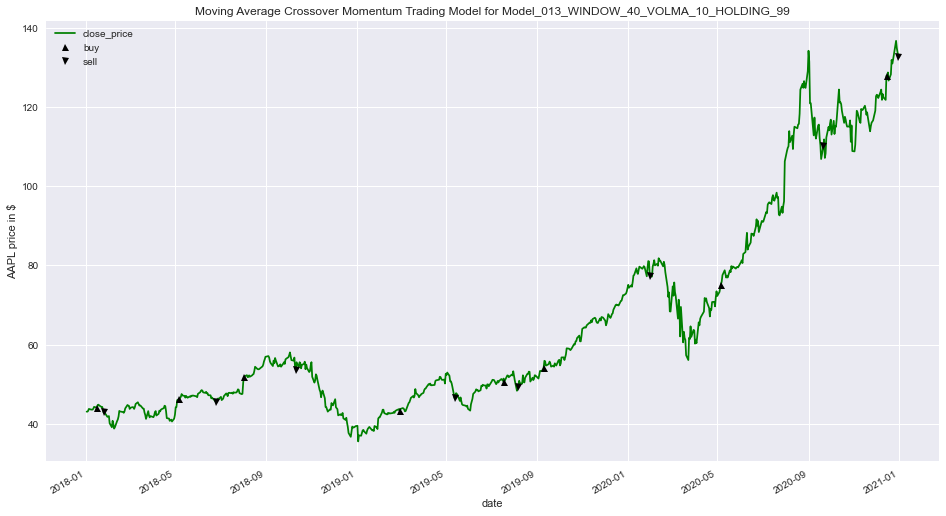

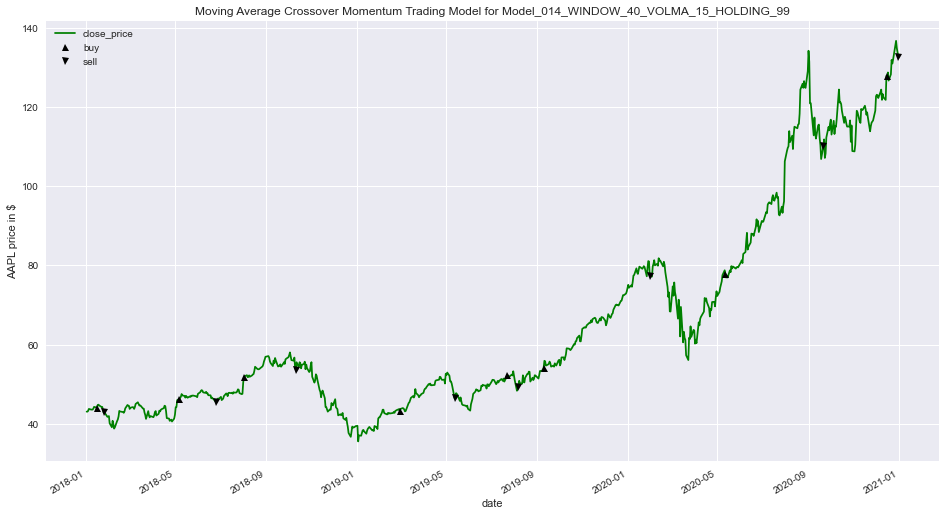

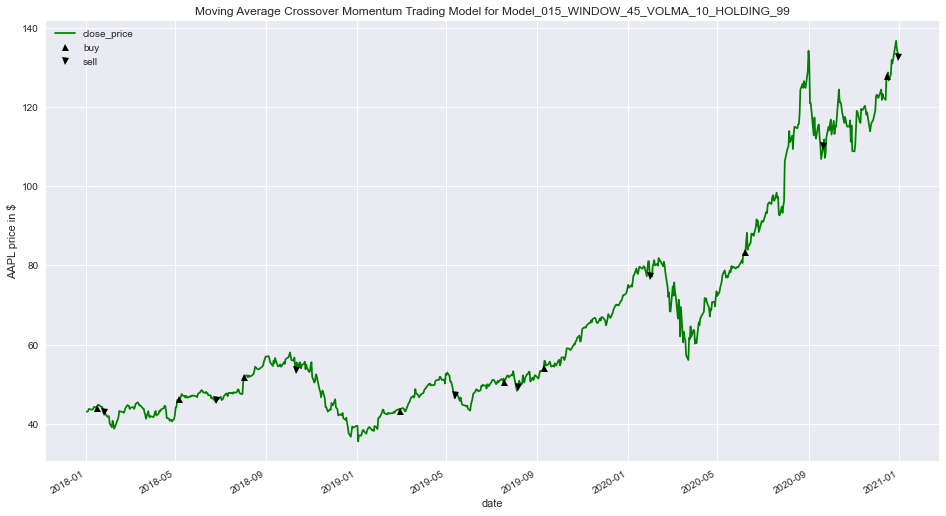

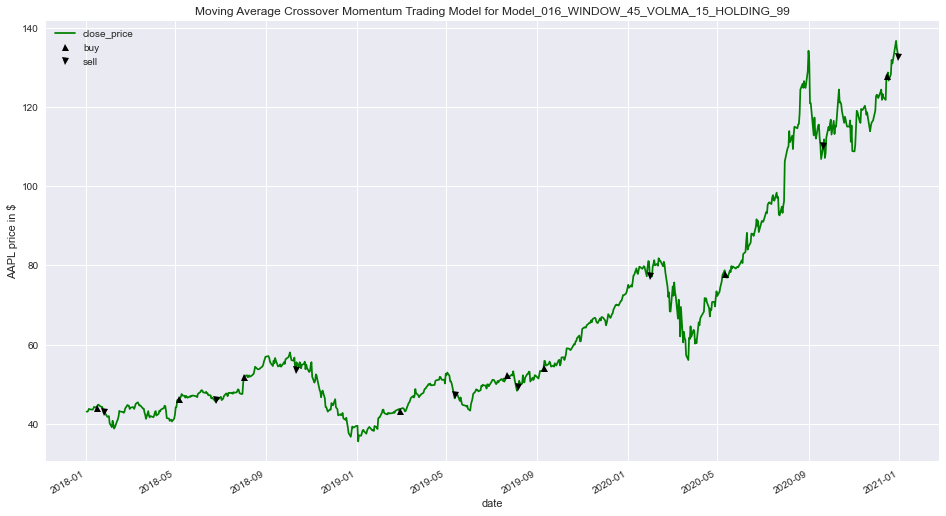

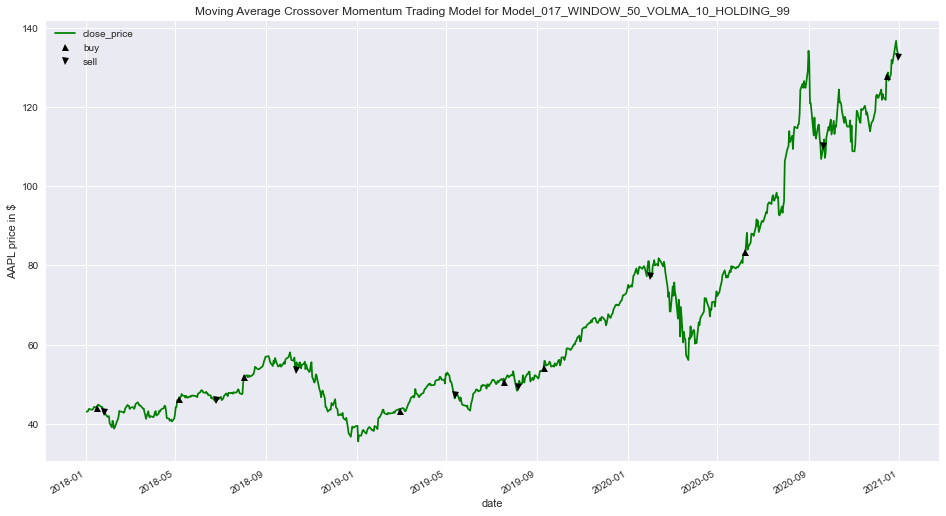

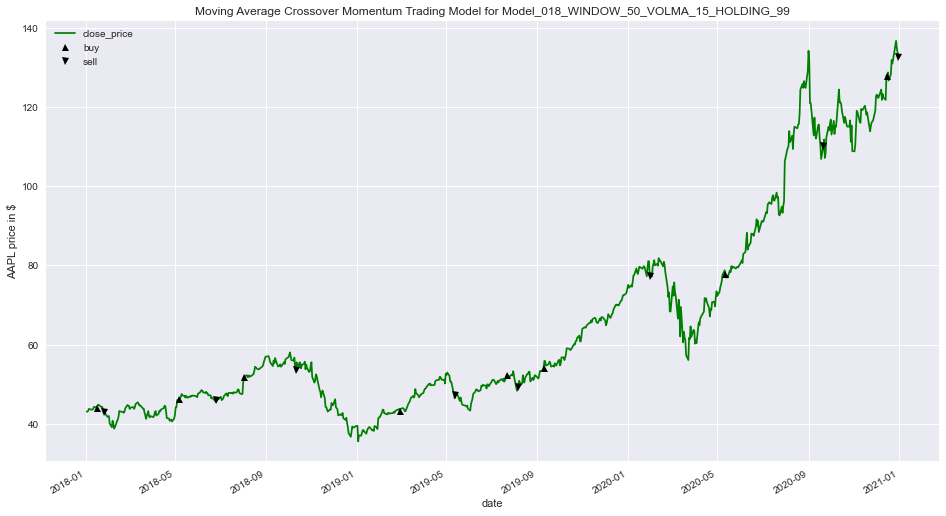

In [17]:
if verbose_graphs:
    for model_name in trading_model_collection:
        draw_model_graph(trading_model_collection[model_name], model_name)

## Task 4 - Back-test Models

In [18]:
def generate_trading_portfolios(trade_model):
    # Construct a portfolio to track the transactions and returns
    portfolio = pd.DataFrame(index=trade_model.index, columns=['trade_action', 'qty_onhand', 'cost_basis', 'sold_transaction', 'gain_loss', 'cash_onhand', 'position_value', 'total_position', 'accum_return'])
    portfolio.iloc[0]['trade_action'] = 0
    portfolio.iloc[0]['qty_onhand'] = 0
    portfolio.iloc[0]['cost_basis'] = 0.00
    portfolio.iloc[0]['sold_transaction'] = 0.00
    portfolio.iloc[0]['gain_loss'] = 0.00
    portfolio.iloc[0]['cash_onhand'] = INITIAL_CAPITAL
    portfolio.iloc[0]['position_value'] = 0.00
    portfolio.iloc[0]['total_position'] = INITIAL_CAPITAL
    portfolio.iloc[0]['accum_return'] = portfolio.iloc[0]['total_position'] - INITIAL_CAPITAL
    recent_cost = 0

    # The conditional parameters below determine how the trading strategy will be carried out
    for i in range(1, len(portfolio)):
        if (trade_model.iloc[i]['entry_exit'] == 1) and (portfolio.iloc[i-1]['qty_onhand'] == 0):
            portfolio.iloc[i]['trade_action'] = 1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] - portfolio.iloc[i]['cost_basis']
            recent_cost = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            if verbose_portfolios: print('BOUGHT QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trade_model.iloc[i]['open_price'])
        elif (trade_model.iloc[i]['entry_exit'] == -1) and (portfolio.iloc[i-1]['qty_onhand'] > 0):
            portfolio.iloc[i]['trade_action'] = -1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = 0.00
            portfolio.iloc[i]['sold_transaction'] = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'] * -1
            portfolio.iloc[i]['gain_loss'] = (recent_cost + (trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'])) * -1
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] + portfolio.iloc[i]['sold_transaction']
            recent_cost = 0.00
            if verbose_portfolios: print('SOLD QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trade_model.iloc[i]['open_price'])
        else:
            portfolio.iloc[i]['trade_action'] = 0
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand']
            portfolio.iloc[i]['cost_basis'] = portfolio.iloc[i-1]['cost_basis']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand']
        portfolio.iloc[i]['position_value'] = trade_model.iloc[i]['close_price'] * portfolio.iloc[i]['qty_onhand']
        portfolio.iloc[i]['total_position'] = portfolio.iloc[i]['cash_onhand'] + portfolio.iloc[i]['position_value']
        portfolio.iloc[i]['accum_return'] = portfolio.iloc[i]['total_position'] - INITIAL_CAPITAL

    if verbose_portfolios: print('\n', portfolio, '\n')
    return portfolio

In [19]:
def calculate_positions_and_performance(trade_model):
    trade_positions = generate_trading_portfolios(trade_model)
    trade_transactions = trade_positions[trade_positions['trade_action'] != 0]
    if verbose_transactions: print(trade_transactions)
    if verbose_transactions:
        if trade_transactions.iloc[-1]['trade_action'] == 1:
            print('The current status of the model is:', 'Holding a position since', trade_transactions.index.tolist()[-1].date(), '\n')
        else:
            print('The current status of the model is:', 'Waiting to enter since', trade_transactions.index.tolist()[-1].date(), '\n')
    return trade_positions

In [20]:
# Convert trading models into positions and calculate profit and loss
# Initialize a dictionary for tracking positions for all models
model_positions_colletion={}

for model_name in trading_model_collection:
    if verbose_portfolios: print('Processing the positions for model:', model_name)
    model_positions_colletion[model_name] = calculate_positions_and_performance(trading_model_collection[model_name])
print(len(model_positions_colletion), 'sets of model positions generated.')

18 sets of model positions generated.


In [21]:
# Initialize a dataframe for storing the model's profit and loss
model_performance_summary = pd.DataFrame(columns=['Model_name','Return_value','Return_percentage'])
for model_name in model_positions_colletion:
    if verbose_positions: print('Processing positions for model:', model_name)
    if verbose_positions: print('Accumulated profit/loss for one share of stock with initial capital of $%.0f at the end of modeling period: $%.2f' % (INITIAL_CAPITAL, model_positions_colletion[model_name].accum_return[-1]))
    if INITIAL_CAPITAL != 0:
        return_percentage = model_positions_colletion[model_name].accum_return[-1] / INITIAL_CAPITAL * 100
        if verbose_positions: print('Accumulated return percentage based on the initial capital investment: %.2f%%' % return_percentage)
    else:
        return_percentage = None
    if verbose_positions: print()
    model_performance_summary = model_performance_summary.append({'Model_name': model_name, 'Return_value': model_positions_colletion[model_name].accum_return[-1], 'Return_percentage': return_percentage}, ignore_index=True)
    model_performance_summary.sort_values(by=['Return_value'], inplace=True, ascending=False)

print(len(model_performance_summary), 'profit/loss summaries generated.\n')
print('The top ten model\'s performance summary:')
print(model_performance_summary.head(10))

Processing positions for model: Model_001_WINDOW_10_VOLMA_10_HOLDING_99
Accumulated profit/loss for one share of stock with initial capital of $0 at the end of modeling period: $41.80

Processing positions for model: Model_002_WINDOW_10_VOLMA_15_HOLDING_99
Accumulated profit/loss for one share of stock with initial capital of $0 at the end of modeling period: $37.36

Processing positions for model: Model_003_WINDOW_15_VOLMA_10_HOLDING_99
Accumulated profit/loss for one share of stock with initial capital of $0 at the end of modeling period: $61.30

Processing positions for model: Model_004_WINDOW_15_VOLMA_15_HOLDING_99
Accumulated profit/loss for one share of stock with initial capital of $0 at the end of modeling period: $57.58

Processing positions for model: Model_005_WINDOW_20_VOLMA_10_HOLDING_99
Accumulated profit/loss for one share of stock with initial capital of $0 at the end of modeling period: $59.02

Processing positions for model: Model_006_WINDOW_20_VOLMA_15_HOLDING_99
Acc

## Task 5 - Evaluate Strategy Performance

In [22]:
# Calculate the stock's performance for a buy-and-hold model
top_model_name = model_performance_summary.loc[0]['Model_name']
top_trading_model = trading_model_collection[top_model_name]
print('The entry point for the buy-and-hold model: $%.2f on %s' % (top_trading_model.iloc[0]['open_price'], top_trading_model.index[0].date()))
print('The exit point for the buy-and-hold model: $%.2f on %s' % (top_trading_model.iloc[-1]['open_price'], top_trading_model.index[-1].date()))
print('The performance of the buy-and-hold model: $%.2f' %(top_trading_model.iloc[-1]['open_price'] - top_trading_model.iloc[0]['open_price']))
print('The performance of the top trading model: $%.2f' %(model_performance_summary.iloc[0]['Return_value']))

The entry point for the buy-and-hold model: $42.54 on 2018-01-02
The exit point for the buy-and-hold model: $134.08 on 2020-12-31
The performance of the buy-and-hold model: $91.54
The performance of the top trading model: $95.90


In [23]:
top_model_positions = model_positions_colletion[top_model_name]
print(top_model_positions[top_model_positions['trade_action'] != 0])

           trade_action qty_onhand cost_basis sold_transaction gain_loss cash_onhand position_value total_position accum_return
date                                                                                                                           
2018-01-16            1          1     44.475            0.000     0.000     -44.475         44.047         -0.428       -0.428
2018-01-26           -1          0      0.000           43.000    -1.475      -1.475          0.000         -1.475       -1.475
2018-05-07            1          1     46.295            0.000     0.000     -47.770         46.290         -1.480       -1.480
2018-06-20           -1          0      0.000           46.587     0.292      -1.183          0.000         -1.183       -1.183
2018-07-25            1          1     48.265            0.000     0.000     -49.448         48.705         -0.743       -0.743
2018-09-24           -1          0      0.000           54.205     5.940       4.757          0.000     

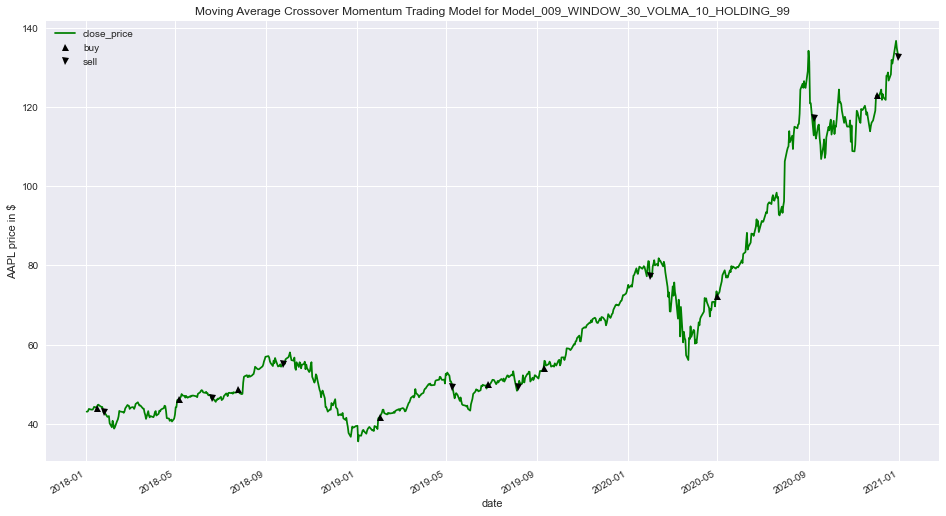

In [24]:
draw_model_graph(trading_model_collection[top_model_name], top_model_name)

In [25]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:00:25.786017
